In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
import statsmodels.formula.api as smf
import scipy


# define directories
# base_dir = "/Users/yxiao/Documents/AM 2022/Quant Investing/ps9"

# load data

# load value and momentaum factors
vmfactors = pd.read_excel("Problem_Set9.xls",
                          sheet_name=0, skiprows=4)
vmfactors["DATE"] = pd.to_datetime(vmfactors["DATE"], format="%Y%m")
vmfactors = vmfactors.set_index("DATE")
vmfactors.index = vmfactors.index.to_period("M").to_timestamp("M")

# load FFF data
FFF = pd.read_excel("Problem_Set9.xls",
                          sheet_name=2, skiprows=0)
FFF = FFF.rename(columns={"Unnamed: 0": "date"})
FFF["date"] = pd.to_datetime(FFF["date"], format="%Y%m")
FFF = FFF.set_index("date")
FFF.index = FFF.index.to_period("M").to_timestamp("M")
FFF = FFF.rename(columns={"Mkt-RF": "Mkt_RF"})

#load TSMOM data
TSMOM = pd.read_excel("Problem_Set9.xls",
                          sheet_name=1, skiprows=2)
TSMOM["DATE"] = pd.to_datetime(TSMOM["DATE"], format="%Y%m")
TSMOM = TSMOM.set_index("DATE")
TSMOM.index = TSMOM.index.to_period("M").to_timestamp("M")

#load AMP factors
AMP = pd.read_excel("Problem_Set9.xls",
                          sheet_name=4, skiprows=3)
AMP["DATE"] = AMP["DATE"].astype(str).apply(lambda x:x[:-2])
AMP["DATE"] = pd.to_datetime(AMP["DATE"], format="%Y%m")
AMP = AMP.set_index("DATE")
AMP.index = AMP.index.to_period("M").to_timestamp("M")

#load HF data
HF = pd.read_excel("Problem_Set9.xls",
                          sheet_name=5, skiprows=1)
HF = HF.rename(columns={"Unnamed: 0": "date"})
HF["date"] = HF["date"].astype(str).apply(lambda x:x.replace('-','')[:-2])
HF["date"] = pd.to_datetime(HF["date"], format="%Y%m")
HF = HF.set_index("date")
HF.index = HF.index.to_period("M").to_timestamp("M")
HFRI = HF.iloc[:,:10]
DJCS = HF.iloc[:,12:22]

#load CArry data
BDC = pd.read_excel("Problem_Set9.xls",
                          sheet_name=3, skiprows=3)
BDC["DATE"] = pd.to_datetime(BDC["DATE"], format="%Y%m")
BDC = BDC.set_index("DATE")
BDC.index = BDC.index.to_period("M").to_timestamp("M")
BDC = BDC.iloc[:,:3]

In [2]:
def port_const(df_rt,weight,strategy_name): #the column name of df had better be the same as the column name of the weight, strategy name should be input with ''
    df_rt = df_rt.copy()
    potfolio_return = pd.DataFrame(columns = {strategy_name})
    for i in range(len(df_rt.index)):
        newreturn = sum(df_rt.iloc[i,:] * weight)
        potfolio_return = potfolio_return.append({strategy_name: newreturn}, ignore_index=True)
    potfolio_return = potfolio_return.set_index(df_rt.index)
    return potfolio_return
    

In [3]:
def statsout(df): #Confidence interval to be continued
    stats_table = pd.DataFrame(columns = df.columns).T
    stats_table['mean'] = df.mean()
    stats_table['std'] = df.std()
    stats_table['count'] = df.count()
    stats_table["sr"] = stats_table["mean"] / stats_table["std"]
    stats_table["asr"] = stats_table["sr"] * np.sqrt(12)
    stats_table["se"] = stats_table["std"] / np.sqrt(stats_table["count"])
    stats_table["tstat"] = stats_table["mean"] / stats_table["se"]
    stats_table["kurt"] = np.power(stats_table["mean"], 4) / np.power(stats_table["std"], 4)
    stats_table["skew"] = np.power(stats_table["mean"], 3) / np.power(stats_table["std"], 3)
    stats_table["ci1_std"] = (1 / (stats_table["count"] - 1) *
                 (1 + (np.square(stats_table["mean"]) /
                       (2 * np.square(stats_table["std"])))))
    stats_table["ci2_std"] = (1 / (stats_table["count"] - 1) *
                 (1 + (np.square(stats_table["sr"]) / 4) *
                  (np.power(stats_table["mean"], 4) / np.power(stats_table["std"], 4)
                   - 1)
                  - stats_table["sr"] * (np.power(stats_table["mean"], 3) /
                                    np.power(stats_table["std"], 3))))
    stats_table["ci1_low"] = stats_table["sr"] - 1.96*stats_table["ci1_std"]
    stats_table["ci1_upper"] = stats_table["sr"] + 1.96*stats_table["ci1_std"]
    stats_table["ci2_low"] = stats_table["sr"] - 1.96*stats_table["ci2_std"]
    stats_table["ci2_upper"] = stats_table["sr"] + 1.96*stats_table["ci1_std"]
    # Calculate percent outside 3 std
    df_1 = df.copy()
    df_1.loc['3std_p'] = df_1.mean() + df_1.std()*3
    df_1.loc['3std_n'] = df_1.mean() - df_1.std()*3
    for i in range(len(df_1.columns)):
        for j in range(len(df_1) -2):
            if  (df_1.iloc[j,i] > df_1.iloc[-2,i] or df_1.iloc[j,i] < df_1.iloc[-1,i]) :
                df_1.iloc[j,i] = 1
            else:
                df_1.iloc[j,i] = 0
    df_1.loc['percent'] = 0          
    for i in range(len(df_1.columns)):
        df_1.iloc[-1,i] = df_1.iloc[:-1,i][df_1.iloc[:-1,i] == 1].sum()/(len(df_1) - 3)
    stats_table["percent_out_3std"] = df_1.iloc[-1,:]
    stats_table = stats_table.drop(columns = {'count','se','ci1_std','ci2_std'})
    return stats_table
            

In [4]:
def MDD(returns):
    returns = returns.dropna()
    cum_rets = (1 + returns).cumprod() - 1
    nav = ((1 + cum_rets) * 100)
    hwm = nav.cummax()
    dd = nav / hwm - 1
    dd_min = dd.min()
    dd_new = dd.reset_index()
    start_date = dd_new.iloc[:,1].idxmin()
    count = 0
    i = start_date
    while i in range(start_date,len(dd_new)):
        count +=1
        i+=1
        if dd_new.iloc[i-1,1] == 0:
            break
    return dd_min, count


In [5]:
def Tangent_weight(return_df,rf_df): #return_df refers to the strategy return dataframe, rf_df refers to the ridk free rate dataframe
    concat_table = pd.concat([return_df,rf_df], axis = 1).dropna()
    ind = concat_table.iloc[:,:-1]
    rf = concat_table.iloc[:,-1]
    ind_mn = ind.mean()
    rf_mn = rf.mean()
    ind_std = ind.std()
    ind_cov = ind.cov()
    ind_icov = np.linalg.inv(ind_cov)
    ones = np.ones(ind_mn.shape[0])
    # form weights
    mvp_w = ind_icov.dot(ones) / ones.dot(ind_icov).dot(ones)
    tan_w = (ind_icov.dot(ind_mn - rf_mn) /
         ones.dot(ind_icov.dot(ind_mn - rf_mn)))
    tangent_w = pd.DataFrame(tan_w, index = return_df.columns,columns = {'Weight'})
    return tangent_w




In [6]:
def calc_eparams(mn, cov, rf_mn):
    """calculate params for eff frontier plot"""

    inv_cov = np.linalg.inv(cov)
    ones = np.ones(mn.shape[0])
    a = ones.dot(np.linalg.inv(cov)).dot(ones)
    b = ones.dot(np.linalg.inv(cov)).dot(mn)
    c = mn.dot(np.linalg.inv(cov)).dot(mn)
    d = a * c - b ** 2

    mn_path = np.linspace(0, 1.5 * max(mn), 100)
    var_path = a * mn_path ** 2 - 2 * b * mn_path + c
    var_path /= d

    tanp_r = (c - b * rf_mn) / (b - a * rf_mn)
    tanp_sig = np.sqrt((c - 2 * rf_mn * b + rf_mn ** 2 * a) /
                       (b - a * rf_mn) ** 2)
    max_std = (max(mn) - rf_mn) / ((tanp_r - rf_mn) / tanp_sig)
    tanp_x = np.linspace(0, max_std * 2, 100)
    tanp_path = rf_mn + tanp_x * (tanp_r - rf_mn) / tanp_sig
    sr = (tanp_r - rf_mn) / tanp_sig
    return mn_path, np.sqrt(var_path), tanp_path, tanp_x, sr,tanp_r,tanp_sig

def EF(return_df,rf_df):  #return_df refers to the strategy return dataframe, rf_df refers to the ridk free rat
    concat_table = pd.concat([return_df,rf_df], axis = 1).dropna()
    ind = concat_table.iloc[:,:-1]
    rf = concat_table.iloc[:,-1]
    ind_mn = ind.mean()
    rf_mn = rf.mean()
    ind_std = ind.std()
    ind_cov = ind.cov()
    mn_path, std_path, tanp_path, tanp_x, sr,tanp_r,tanp_sig = calc_eparams(ind_mn, ind_cov, rf_mn)
    plt.plot(std_path, mn_path, label="Eff Frontier", color="b")
#     plt.plot(tanp_x, tanp_path, color="g")
    plt.scatter(ind.std(), ind.mean(), label="Strategies", color="r")
    plt.scatter(tanp_sig, tanp_r, label="tangent_portfolio", color="g")
    plt.legend()
    plt.title("Strategy Mean")
    plt.savefig("1a.png")
    return sr

In [7]:
def GRS_test(port_df, factor_df, rf, LOLS): #input 'LO' or 'LS'
    """fit various portfolio summaries and GRS test

    Parameters
    ----------
    port_df : pandas DataFrame
        each column corresponds to a portfolio return to test
        index corresponds to dates
        (should align with factor_df format)
    factor_df : pandas DataFrame
        each column corresponds to a factor
        index corresponds to dates
        (should align with portfolio_df format)
    rf : pandas Series
        risk-free rate

    Returns
    -------
    port_agg : pandas DataFrame
        Sharpe ratio and aggregates for portfolios
    params : pandas DataFrame
        matrix of alphas/betas and t-stats
    grs : scalar
        GRS test stat
    grs_pval : scalar
        p-values for GRS test stat
    """

    # get labels and merge
    pf_lab = list(port_df.columns)
    factor_lab = list(factor_df.columns)
    factor_df = factor_df[factor_df.index.isin(port_df.index)]
    rf = rf[rf.index.isin(port_df.index)]
    port_df = port_df[port_df.index.isin(factor_df.index)]
    rf = rf[rf.index.isin(factor_df.index)]

    port_agg = port_df.aggregate(["mean", "std"]).T
    port_agg["sr"] = port_agg["mean"] / port_agg["std"]
    port_agg["sr"] -= (rf.mean() / port_agg["std"])
    # annualize
    port_agg["sr"] *= np.sqrt(12)

    # fit TS regression
    alpha_l = []
    params_l = []
    resid_l = []
    R_square = []
    for c in port_df.columns:
        if LOLS == 'LO':
            mod = sm.OLS(port_df[c] - rf, sm.add_constant(factor_df))
        else:
            mod = sm.OLS(port_df[c] , sm.add_constant(factor_df))
        fit = mod.fit()
        params = fit.params
        params_l.append(params)
        summary = mod.fit().summary().tables[0].as_html()
        summary_read = pd.read_html(summary, header = 0, index_col = 0)[0].columns[2]
        R_square.append(summary_read)
        resid = fit.resid
        resid.name = c
        resid_l.append(resid)
    params = pd.DataFrame(params_l, index=port_df.columns)
    R_squared = pd.DataFrame(R_square, index=port_df.columns, columns = {'R_square'})
    alpha = params["const"]
    resid = pd.concat(resid_l, axis=1)
    table = pd.concat([params.iloc[:,0],R_squared], axis = 1)

    # calculate GRS test stat
    T, N = port_df.shape
    L = 1
    factor_mn = factor_df.mean()
    factor_cov = factor_df.cov()
    factor_ssr = factor_mn.T.dot(np.linalg.inv(factor_cov))
    factor_ssr = factor_ssr.dot(factor_mn)
    Sigma = resid.T.dot(resid) / (T-L-1)
    grs = alpha.T.dot(np.linalg.inv(Sigma)).dot(alpha)
    grs /= (1 + factor_ssr)
    grs *= ((T/N) * (T-N-L) / (T-L-1))
    grs_pval = 1. - scipy.stats.f.cdf(grs, N, T-N-L)

    return table, grs, grs_pval

In [8]:
#Part one Qa
df = vmfactors.copy()
port_summary = statsout(df)
port_summary

,mean,std,sr,asr,tstat,kurt,skew,ci1_low,ci1_upper,ci2_low,ci2_upper,percent_out_3std
VAL^US,0.002706,0.043767,0.061839,0.214217,1.418262,0.000015,0.000236,0.058099,0.065580,0.058109,0.065580,0.018975
MOM^US,0.006080,0.046268,0.131415,0.455236,3.013969,0.000298,0.002270,0.127650,0.135181,0.127699,0.135181,0.015180
VAL^UK,0.002796,0.040900,0.068373,0.236852,1.389508,0.000022,0.000320,0.063605,0.073142,0.063622,0.073142,0.013283
MOM^UK,0.006773,0.043140,0.156989,0.543827,3.603925,0.000607,0.003869,0.153217,0.160762,0.153288,0.160762,0.026565
VAL^EU,0.002604,0.030263,0.086038,0.298044,1.748499,0.000055,0.000637,0.081263,0.090813,0.081290,0.090813,0.013283
MOM^EU,0.007499,0.037565,0.199629,0.691535,4.472761,0.001588,0.007956,0.195639,0.203619,0.195762,0.203619,0.011385
VAL^JP,0.007581,0.040449,0.187416,0.649226,3.808733,0.001234,0.006583,0.182575,0.192256,0.182706,0.192256,0.011385
MOM^JP,0.001965,0.046529,0.042222,0.146263,0.946008,0.000003,0.000075,0.038307,0.046138,0.038312,0.046138,0.017078
VAL^EQ,0.002932,0.026732,0.109686,0.379964,2.365257,0.000145,0.001320,0.105437,0.113936,0.105475,0.113936,0.007590
MOM^EQ,0.005106,0.032367,0.157759,0.546494,3.401899,0.000619,0.003926,0.153483,0.162036,0.153564,0.162036,0.007590


In [9]:
#Qb
from scipy import stats

def multi_t(vars):
    vars = vars.dropna()
    t_stats = dict()
    for i in vars.columns:
        for j in vars.columns:
            t_stats[i, j] = stats.ttest_ind(vars[i], vars[j])[0]
    for k, t in t_stats.items():
        if t>2:
            return "reject", k, t
    return "cannot reject"

print("Val:", multi_t(vmfactors[["VAL^US","VAL^UK",
                                  "VAL^EU","VAL^JP","VAL^EQ","VAL^FX","VAL^FI","VAL^CM"]]))
print("Mom:", multi_t(vmfactors[["MOM^US","MOM^UK",
                                 "MOM^EU","MOM^JP","MOM^EQ","MOM^FX","MOM^FI","MOM^CM"]]))


Val: ('reject', ('VAL^JP', 'VAL^EQ'), 2.0458144875251496)
Mom: ('reject', ('MOM^UK', 'MOM^FX'), 2.167298838831195)


Qb: If any two of the value premiums do not equal, we can reject. Or to say, if any t-stat between each pair is bigger than 2, we can reject.

In [10]:
#Qc
MDD_summary = pd.DataFrame(columns = ['MDD','Duration_in_month'])
for k in range(len(vmfactors.columns)):
    Max_DD,duration = MDD(vmfactors.iloc[:,k])
    MDD_summary = MDD_summary.append({'MDD': Max_DD,'Duration_in_month': duration}, ignore_index=True)
MDD_summary

,MDD,Duration_in_month
0,-0.715798,58.0
1,-0.530113,90.0
2,-0.675426,42.0
3,-0.579245,21.0
4,-0.511250,14.0
5,-0.449104,52.0
6,-0.695836,31.0
7,-0.464072,46.0
8,-0.389787,1.0
9,-0.195301,32.0


In [11]:
# Qd
value_strategy = statsout(df).iloc[::2]
mom_strategy = statsout(df).iloc[1::2]
value_strategy['weight'] = 1/value_strategy['std']/(1/value_strategy['std']).sum()
mom_strategy['weight'] = 1/mom_strategy['std']/(1/mom_strategy['std']).sum()
weight_val = value_strategy['weight'].T
weight_Mom = mom_strategy['weight'].T
value_strategy_rt = vmfactors[value_strategy.index]
mom_strategy_rt = vmfactors[mom_strategy.index]

In [12]:
Val_everywhere = port_const(value_strategy_rt,weight_val,'Val_everywhere')
Val_everywhere_summary = statsout(Val_everywhere)
Val_everywhere_summary['MDD'] =  MDD(Val_everywhere)[0]
Val_everywhere_summary

,mean,std,sr,asr,tstat,kurt,skew,ci1_low,ci1_upper,ci2_low,ci2_upper,percent_out_3std,MDD
Val_everywhere,0.002548,0.016046,0.158767,0.549986,3.155435,0.000635,0.004002,0.15373,0.163804,0.153827,0.163804,0.013283,-0.310209


In [13]:
Mom_everywhere = port_const(mom_strategy_rt,weight_Mom,'Mom_everywhere')
Mom_everywhere_summary = statsout(Mom_everywhere)
Mom_everywhere_summary['MDD'] = MDD(Mom_everywhere)[0]
Mom_everywhere_summary

,mean,std,sr,asr,tstat,kurt,skew,ci1_low,ci1_upper,ci2_low,ci2_upper,percent_out_3std,MDD
Mom_everywhere,0.003677,0.019409,0.189446,0.656259,3.765156,0.001288,0.006799,0.184382,0.194509,0.184522,0.194509,0.011385,-0.208154


In [14]:
# Qe
vmfactors_cp = vmfactors.copy()
vmfactors_cp.loc['weight'] = 0.5
US_equity = port_const(vmfactors_cp.iloc[:-1,:2],vmfactors_cp.iloc[-1,:2],'US_equity')
UK_equity = port_const(vmfactors_cp.iloc[:-1,2:4],vmfactors_cp.iloc[-1,2:4],'UK_equity')
EU_equity = port_const(vmfactors_cp.iloc[:-1,4:6],vmfactors_cp.iloc[-1,4:6],'EU_equity')
JP_equity = port_const(vmfactors_cp.iloc[:-1,6:8],vmfactors_cp.iloc[-1,6:8],'JP_equity')
Equity = port_const(vmfactors_cp.iloc[:-1,8:10],vmfactors_cp.iloc[-1,8:10],'Equity')
Currency = port_const(vmfactors_cp.iloc[:-1,10:12],vmfactors_cp.iloc[-1,10:12],'Currency')
FI = port_const(vmfactors_cp.iloc[:-1,12:14],vmfactors_cp.iloc[-1,12:14],'FI')
COM = port_const(vmfactors_cp.iloc[:-1,14:16],vmfactors_cp.iloc[-1,14:16],'COM')
five_to_five_com = pd.concat([US_equity, UK_equity,EU_equity,JP_equity,Equity,Currency,FI,COM], axis=1)
five_to_five_com_summary = statsout(five_to_five_com)

In [15]:
MDD_summary_55 = pd.DataFrame(columns = ['MDD','Duration_in_month'])
for k in range(len(five_to_five_com.columns)):
    Max_DD_55,duration_55 = MDD(five_to_five_com.iloc[:,k])
    MDD_summary_55 = MDD_summary_55.append({'MDD': Max_DD_55,'Duration_in_month': duration_55}, ignore_index=True)
MDD_summary_55 = MDD_summary_55.set_index (five_to_five_com_summary.index)
five_to_five_com_summary['MDD'] = MDD_summary_55['MDD']
five_to_five_com_summary

,mean,std,sr,asr,tstat,kurt,skew,ci1_low,ci1_upper,ci2_low,ci2_upper,percent_out_3std,MDD
US_equity,0.004393,0.019097,0.230061,0.796955,5.276377,0.002801,0.012177,0.226229,0.233893,0.226387,0.233893,0.013283,-0.186060
UK_equity,0.005508,0.018500,0.297736,1.031388,6.050711,0.007858,0.026393,0.292768,0.302704,0.293121,0.302704,0.015180,-0.144167
EU_equity,0.004541,0.016872,0.269158,0.932390,5.469936,0.005248,0.019499,0.264228,0.274088,0.264511,0.274088,0.009488,-0.120521
JP_equity,0.004565,0.019070,0.239384,0.829252,4.864867,0.003284,0.013718,0.234491,0.244278,0.234711,0.244278,0.011385,-0.141068
Equity,0.004019,0.016424,0.244715,0.847717,5.276998,0.003586,0.014655,0.240364,0.249066,0.240569,0.249066,0.005693,-0.173650
Currency,0.002498,0.013503,0.184989,0.640819,3.893559,0.001171,0.006330,0.180478,0.189499,0.180597,0.189499,0.009488,-0.085542
FI,0.000606,0.009450,0.064112,0.222092,1.274209,0.000017,0.000264,0.059128,0.069097,0.059143,0.069097,0.013283,-0.076531
COM,0.007372,0.032640,0.225855,0.782386,5.184845,0.002602,0.011521,0.222034,0.229677,0.222186,0.229677,0.005693,-0.270599


In [16]:
#Qf
vmfactors_cp2 = vmfactors.copy()
vmfactors_cp2.loc['std_inv'] = 1/port_summary['std'].T
vmfactors_cp2.loc['weight'] = 0
for i in range(0,len(vmfactors_cp2.columns)-1,2):
    vmfactors_cp2.iloc[-1,i] = vmfactors_cp2.iloc[-2,i]/vmfactors_cp2.iloc[-2,i:i+2].sum()
    vmfactors_cp2.iloc[-1,i+1] = vmfactors_cp2.iloc[-2,i+1]/vmfactors_cp2.iloc[-2,i:i+2].sum()
vmfactors_cp2.drop(vmfactors_cp2.index[-2], axis=0, inplace=True) 

In [17]:
US_equity = port_const(vmfactors_cp2.iloc[:-1,:2],vmfactors_cp2.iloc[-1,:2],'US_equity')
UK_equity = port_const(vmfactors_cp2.iloc[:-1,2:4],vmfactors_cp2.iloc[-1,2:4],'UK_equity')
EU_equity = port_const(vmfactors_cp2.iloc[:-1,4:6],vmfactors_cp2.iloc[-1,4:6],'EU_equity')
JP_equity = port_const(vmfactors_cp2.iloc[:-1,6:8],vmfactors_cp2.iloc[-1,6:8],'JP_equity')
Equity = port_const(vmfactors_cp2.iloc[:-1,8:10],vmfactors_cp2.iloc[-1,8:10],'Equity')
Currency = port_const(vmfactors_cp2.iloc[:-1,10:12],vmfactors_cp2.iloc[-1,10:12],'Currency')
FI = port_const(vmfactors_cp2.iloc[:-1,12:14],vmfactors_cp2.iloc[-1,12:14],'FI')
COM = port_const(vmfactors_cp2.iloc[:-1,14:16],vmfactors_cp2.iloc[-1,14:16],'COM')
five_to_five_com_2 = pd.concat([US_equity, UK_equity,EU_equity,JP_equity,Equity,Currency,FI,COM], axis=1)
five_to_five_com_summary_2 = statsout(five_to_five_com_2)

In [18]:
MDD_summary_inv = pd.DataFrame(columns = ['MDD','Duration_in_month'])
for k in range(len(five_to_five_com_2.columns)):
    Max_DD_inv,duration_inv = MDD(five_to_five_com_2.iloc[:,k])
    MDD_summary_inv = MDD_summary_inv.append({'MDD': Max_DD_inv,'Duration_in_month': duration_inv}, ignore_index=True)
MDD_summary_inv = MDD_summary_inv.set_index (five_to_five_com_summary_2.index)
five_to_five_com_summary_2['MDD'] = MDD_summary_inv['MDD']
five_to_five_com_summary_2

,mean,std,sr,asr,tstat,kurt,skew,ci1_low,ci1_upper,ci2_low,ci2_upper,percent_out_3std,MDD
US_equity,0.004347,0.019048,0.228185,0.790455,5.233346,0.002711,0.011881,0.224354,0.232015,0.224510,0.232015,0.013283,-0.177395
UK_equity,0.005436,0.018368,0.295938,1.025160,6.014176,0.007670,0.025918,0.290973,0.300904,0.291321,0.300904,0.013283,-0.150441
EU_equity,0.004333,0.016222,0.267090,0.925227,5.427909,0.005089,0.019053,0.262163,0.272017,0.262441,0.272017,0.007590,-0.151049
JP_equity,0.004776,0.018609,0.256643,0.889039,5.215610,0.004338,0.016904,0.251729,0.261557,0.251985,0.261557,0.011385,-0.180745
Equity,0.003916,0.016107,0.243099,0.842120,5.242155,0.003492,0.014366,0.238750,0.247448,0.238952,0.247448,0.007590,-0.193462
Currency,0.002501,0.013468,0.185699,0.643281,3.908515,0.001189,0.006404,0.181188,0.190210,0.181308,0.190210,0.009488,-0.089146
FI,0.000601,0.009369,0.064135,0.222169,1.274653,0.000017,0.000264,0.059150,0.069120,0.059165,0.069120,0.013283,-0.077542
COM,0.007425,0.032584,0.227857,0.789321,5.230802,0.002696,0.011830,0.224034,0.231680,0.224189,0.231680,0.007590,-0.272636


#### Qg
#### Combining across asset classes: The Sharpe ratio and MDD both improved compared to non-diversification case
#### Combining two factors: The Sharpe ratio and MDD both improved compared to non-diversification case
#### The benefit of diversification resulted more from factor combination in this case, in that the sharpe ratios are higher compared to asset class combination.

In [19]:
#Qh
rf_df = FFF['RF']
tan_weight = Tangent_weight(vmfactors,rf_df)
tan_weight

,Weight
VAL^US,0.018165
MOM^US,0.008038
VAL^UK,0.004172
MOM^UK,0.013963
VAL^EU,0.036058
MOM^EU,0.010230
VAL^JP,0.019990
MOM^JP,0.029589
VAL^EQ,0.104192
MOM^EQ,0.059705


#### The weights for Fixed income and Currencies are high. Weights for value factors are higher than moment factors across assets.

-52.00977209842976

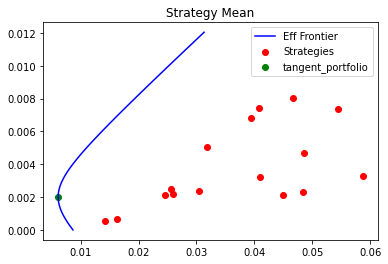

In [20]:
#Qh
# shiayn = port_const(vmfactors.dropna(),Tangent_weight(vmfactors.dropna(),rf_df).T.iloc[0,:],'strategy_name')
# plt.scatter(shiayn.std(), shiayn.mean(), label="tangent_portfolio", color="g")
EF(vmfactors.dropna(),rf_df)

In [21]:
#Qi
odd_vmfactors = vmfactors[::2]
even_vmfactors = vmfactors[1::2]
weight_for_even = Tangent_weight(odd_vmfactors,rf_df).T.iloc[0,:]
weight_for_odd = Tangent_weight(even_vmfactors,rf_df).T.iloc[0,:]
even_outsample = port_const(even_vmfactors,weight_for_even,'Portfolio_cross')
odd_outsample = port_const(odd_vmfactors,weight_for_odd,'Portfolio_cross')
portfolio_cross = pd.concat([odd_outsample,even_outsample])
portfolio_cross.sort_index(inplace=True)

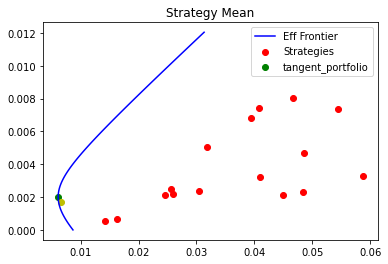

In [22]:
tanp_r = portfolio_cross.mean()
tanp_sig = portfolio_cross.std()
rf_mn = rf_df.mean()
EF(vmfactors.dropna(),rf_df)
plt.scatter(tanp_sig, tanp_r, label ='new tangent_port',color="y")

#### The new tangent portfolio is more southeast-bound.

In [23]:
#Qj
cov_matrix = vmfactors.cov()
cov_matrix

,VAL^US,MOM^US,VAL^UK,MOM^UK,VAL^EU,MOM^EU,VAL^JP,MOM^JP,VAL^EQ,MOM^EQ,VAL^FX,MOM^FX,VAL^FI,MOM^FI,VAL^CM,MOM^CM
VAL^US,0.001916,-0.001299,0.001191,-0.000828,0.000852,-0.000526,7.670967e-04,-0.000455,0.000175,-0.000219,-0.000019,0.000002,-1.877898e-05,-0.000005,0.000198,-0.000402
MOM^US,-0.001299,0.002141,-0.001010,0.001226,-0.000749,0.000968,-5.947125e-04,0.000667,-0.000149,0.000498,-0.000094,0.000166,1.345425e-05,0.000061,-0.000397,0.000576
VAL^UK,0.001191,-0.001010,0.001673,-0.001212,0.000795,-0.000633,7.284551e-04,-0.000558,0.000269,-0.000336,0.000052,-0.000088,1.929641e-05,-0.000005,0.000130,-0.000276
MOM^UK,-0.000828,0.001226,-0.001212,0.001861,-0.000798,0.001060,-4.864609e-04,0.000598,-0.000203,0.000538,-0.000161,0.000213,-2.376694e-05,0.000065,-0.000203,0.000421
VAL^EU,0.000852,-0.000749,0.000795,-0.000798,0.000916,-0.000647,4.484032e-04,-0.000415,0.000309,-0.000299,0.000119,-0.000079,-2.324525e-05,-0.000029,0.000173,-0.000230
MOM^EU,-0.000526,0.000968,-0.000633,0.001060,-0.000647,0.001411,-3.287280e-04,0.000556,-0.000270,0.000685,-0.000164,0.000257,-5.409562e-05,0.000075,-0.000155,0.000415
VAL^JP,0.000767,-0.000595,0.000728,-0.000486,0.000448,-0.000329,1.636090e-03,-0.001272,0.000151,-0.000153,0.000170,-0.000150,-9.144972e-07,0.000027,-0.000057,-0.000009
MOM^JP,-0.000455,0.000667,-0.000558,0.000598,-0.000415,0.000556,-1.271560e-03,0.002165,-0.000186,0.000312,-0.000156,0.000245,-2.913846e-05,0.000018,0.000225,0.000086
VAL^EQ,0.000175,-0.000149,0.000269,-0.000203,0.000309,-0.000270,1.506714e-04,-0.000186,0.000715,-0.000342,0.000014,-0.000063,-2.469248e-05,-0.000011,0.000030,-0.000167
MOM^EQ,-0.000219,0.000498,-0.000336,0.000538,-0.000299,0.000685,-1.528554e-04,0.000312,-0.000342,0.001048,-0.000077,0.000142,-3.908700e-05,0.000056,-0.000235,0.000445


#### The correlation between value and value factors are almost positive
#### The correlation between momentum and momentum factors are almost positive
#### The correlation between value and momentum factors are almost negative
#### Therefore, combining value and momentum serves to have better diversification effect

In [24]:
#Qk
import statsmodels.api as sm

vmfactors = vmfactors.dropna()
alpha = dict()
R2 = dict()
mdl = dict()
y_pred = dict()

for i in vmfactors.columns:
    sum_weights = port_summary["std"].sum()-port_summary["std"][i]
    y = vmfactors[i]
    x = (vmfactors @ port_summary["std"] - vmfactors[i]*port_summary["std"][i])/sum_weights
    mdl[i] = sm.OLS(y, x)
    results = mdl[i].fit()
    alpha[i] = results.params[0]
    R2[i] = results.rsquared
    y_pred[i] = results.predict(x).mean()
alpha, R2


({'VAL^US': -0.636782760238488,
  'MOM^US': 0.3501892581836299,
  'VAL^UK': -0.5141871900703171,
  'MOM^UK': 0.9476053135872665,
  'VAL^EU': -0.27290624543711106,
  'MOM^EU': 1.396353149851739,
  'VAL^JP': -0.33432001273989587,
  'MOM^JP': 0.15406972662468776,
  'VAL^EQ': -0.228258697717192,
  'MOM^EQ': 0.7655814814124269,
  'VAL^FX': -0.09291257400040867,
  'MOM^FX': 0.3296778025231051,
  'VAL^FI': -0.0482340081061169,
  'MOM^FI': 0.10233411699711985,
  'VAL^CM': -1.1276677537894568,
  'MOM^CM': -0.3944202312727668},
 {'VAL^US': 0.03438496723399842,
  'MOM^US': 0.0074160639986208254,
  'VAL^UK': 0.02662430988786635,
  'MOM^UK': 0.05372788303370635,
  'VAL^EU': 0.012967216032704343,
  'MOM^EU': 0.1606288022655067,
  'VAL^JP': 0.010708792028745195,
  'MOM^JP': 0.0014996114245759973,
  'VAL^EQ': 0.012484390853802374,
  'MOM^EQ': 0.08156099958643681,
  'VAL^FX': 0.0022113056054424707,
  'MOM^FX': 0.024235290569839973,
  'VAL^FI': 0.0013399944792629181,
  'MOM^FI': 0.00785320954614177,
  '

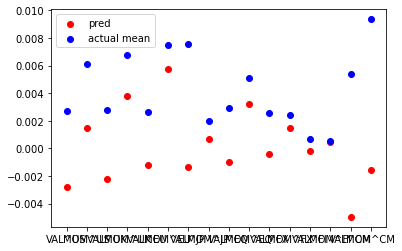

In [25]:
plt.scatter(y_pred.keys(), y_pred.values(), color="red", label="pred")
plt.scatter(y_pred.keys(), port_summary["mean"], color="blue", label = "actual mean")
plt.legend()
# , port_summary["mean"]

For GRS F-test, it is to test whether all alphas are zero. We can test on that, and it is very likely to reject. Many strategies seem to have large alphas, such as 'MOM^EU': 2.49

In [26]:
#Ql
Model_CAPM = FFF[['Mkt_RF']].replace(-99.99, np.nan).replace(-999, np.nan).dropna()
Model_FF4F = FFF[['Mkt_RF','SMB','HML','UMD']].replace(-99.99, np.nan).replace(-999, np.nan).dropna()
Model_AMP3 = pd.concat([Model_CAPM, AMP[['VAL','MOM']]], axis = 1).replace(-99.99, np.nan).replace(-999, np.nan).dropna()
Model_AMP3TS = pd.concat([Model_AMP3,TSMOM[['TSMOM']]], axis = 1).replace(-99.99, np.nan).replace(-999, np.nan).dropna()
Model_5 = pd.concat([Model_AMP3TS,FFF[['LTREV','STREV']]], axis = 1).replace(-99.99, np.nan).replace(-999, np.nan).dropna()

In [27]:
GRS_Model1 = GRS_test(vmfactors.dropna(),Model_CAPM,rf_df,'LS')
GRS_Model1

(           const R_square
 VAL^US  0.003554    0.044
 MOM^US  0.005221    0.005
 VAL^UK  0.003018    0.001
 MOM^UK  0.009030    0.021
 VAL^EU  0.001986    0.007
 MOM^EU  0.008066    0.043
 VAL^JP  0.008012    0.009
 MOM^JP  0.002728    0.004
 VAL^EQ  0.002227    0.005
 MOM^EQ  0.005195    0.001
 VAL^FX  0.002009    0.002
 MOM^FX  0.002308    0.001
 VAL^FI  0.000750    0.001
 MOM^FI  0.000448    0.002
 VAL^CM  0.003117    0.000
 MOM^CM  0.007390    0.000,
 5.604807617847573,
 7.462486184550698e-11)

In [28]:
GRS_Model2 = GRS_test(vmfactors.dropna(),Model_FF4F,rf_df,'LS')
GRS_Model2 

(           const R_square
 VAL^US  0.002370    0.783
 MOM^US -0.000748    0.885
 VAL^UK  0.002656    0.354
 MOM^UK  0.005390    0.454
 VAL^EU  0.001917    0.397
 MOM^EU  0.004915    0.421
 VAL^JP  0.007668    0.147
 MOM^JP  0.000699    0.142
 VAL^EQ  0.002004    0.061
 MOM^EQ  0.003269    0.120
 VAL^FX  0.002495    0.022
 MOM^FX  0.001540    0.035
 VAL^FI  0.000913    0.005
 MOM^FI  0.000129    0.025
 VAL^CM  0.005440    0.037
 MOM^CM  0.005247    0.055,
 4.105035497202548,
 2.7403269964310084e-07)

In [29]:
GRS_Model3 = GRS_test(vmfactors.dropna(),Model_AMP3,rf_df,'LS')
GRS_Model3

(           const R_square
 VAL^US -0.000586    0.568
 MOM^US -0.000129    0.656
 VAL^UK -0.000623    0.554
 MOM^UK  0.003421    0.645
 VAL^EU -0.000118    0.547
 MOM^EU  0.003117    0.620
 VAL^JP  0.004306    0.342
 MOM^JP -0.000256    0.318
 VAL^EQ  0.002100    0.089
 MOM^EQ  0.001906    0.276
 VAL^FX  0.001420    0.097
 MOM^FX -0.000313    0.159
 VAL^FI -0.001663    0.177
 MOM^FI -0.001023    0.159
 VAL^CM  0.000063    0.075
 MOM^CM  0.002480    0.142,
 1.6490911660580125,
 0.05497598564100559)

In [30]:
GRS_Model4 = GRS_test(vmfactors.dropna(),Model_AMP3TS,rf_df,'LS')
GRS_Model4

(           const R_square
 VAL^US -0.003630    0.610
 MOM^US  0.002504    0.692
 VAL^UK -0.001912    0.575
 MOM^UK  0.004430    0.664
 VAL^EU -0.001926    0.587
 MOM^EU  0.002172    0.652
 VAL^JP  0.004570    0.358
 MOM^JP  0.000365    0.339
 VAL^EQ  0.001927    0.114
 MOM^EQ  0.000746    0.296
 VAL^FX  0.002608    0.113
 MOM^FX -0.002810    0.252
 VAL^FI -0.000395    0.146
 MOM^FI -0.001284    0.180
 VAL^CM  0.000712    0.097
 MOM^CM -0.000544    0.208,
 1.4848968896536048,
 0.10313838079571658)

In [31]:
GRS_Model5 = GRS_test(vmfactors.dropna(),Model_5,rf_df,'LS')
GRS_Model5

(           const R_square
 VAL^US -0.003784    0.614
 MOM^US  0.002895    0.711
 VAL^UK -0.001913    0.575
 MOM^UK  0.004379    0.668
 VAL^EU -0.001902    0.588
 MOM^EU  0.001943    0.662
 VAL^JP  0.004381    0.368
 MOM^JP  0.000479    0.342
 VAL^EQ  0.001956    0.124
 MOM^EQ  0.000694    0.301
 VAL^FX  0.002778    0.129
 MOM^FX -0.002946    0.261
 VAL^FI -0.000384    0.150
 MOM^FI -0.001378    0.223
 VAL^CM  0.000424    0.105
 MOM^CM -0.000362    0.215,
 1.5169982732568041,
 0.09169547057166927)

#### Both the CAPM and Fama-French 4-factor model satisfiy the GRS test. The R squres of the FF4F model are generally higher than the CAPM. Therefore,  Fama-French 4-factor model best prices the portfolios.

In [32]:
#Part 2
# Qm
# load value and momentaum factors
tsmom = pd.read_excel("Problem_Set9.xls",
                          sheet_name=1, skiprows=2)
tsmom["DATE"] = pd.to_datetime(tsmom["DATE"], format="%Y%m")
tsmom = tsmom.set_index("DATE")
tsmom.index = tsmom.index.to_period("M").to_timestamp("M")
mom_tsmom = pd.concat([vmfactors[["MOM^EQ", "MOM^FX", "MOM^FI", "MOM^CM"]], 
                         tsmom[["TSMOM^EQ","TSMOM^FX","TSMOM^FI","TSMOM^CM"]]], axis=1).dropna()
# test using correlation
corr_EQ = np.cov(mom_tsmom["MOM^EQ"],tsmom["TSMOM^EQ"])/(mom_tsmom["MOM^EQ"].std()*tsmom["TSMOM^EQ"].std())
corr_FX = np.cov(mom_tsmom["MOM^FX"],tsmom["TSMOM^FX"])/(mom_tsmom["MOM^FX"].std()*tsmom["TSMOM^FX"].std())
corr_FI = np.cov(mom_tsmom["MOM^FI"],tsmom["TSMOM^FI"])/(mom_tsmom["MOM^FI"].std()*tsmom["TSMOM^FI"].std())
corr_CM = np.cov(mom_tsmom["MOM^CM"],tsmom["TSMOM^CM"])/(mom_tsmom["MOM^CM"].std()*tsmom["TSMOM^CM"].std())

print("EQ:", corr_EQ[0][1], "FX:",corr_FX[0][1], "FI:",corr_FI[0][1], "CM:",corr_CM[0][1] )

EQ: 0.381728277903662 FX: 0.7171886012506098 FI: 0.404567991196152 CM: 0.6694706908124076


In [33]:
# test using t-test
from scipy import stats
t_EQ = stats.ttest_ind(mom_tsmom["MOM^EQ"],tsmom["TSMOM^EQ"])
t_FX = stats.ttest_ind(mom_tsmom["MOM^FX"],tsmom["TSMOM^FX"])
t_FI = stats.ttest_ind(mom_tsmom["MOM^FI"],tsmom["TSMOM^FI"])
t_CM = stats.ttest_ind(mom_tsmom["MOM^CM"],tsmom["TSMOM^CM"])

print("EQ:", t_EQ)
print("FX:",t_FX)
print("FI:",t_FI)
print("CM:",t_CM)

EQ: Ttest_indResult(statistic=-2.7576524660281385, pvalue=0.005965375593071663)
FX: Ttest_indResult(statistic=-3.057898003389741, pvalue=0.002309263504992706)
FI: Ttest_indResult(statistic=-4.043054509060369, pvalue=5.8288456305747095e-05)
CM: Ttest_indResult(statistic=-0.7870467676675176, pvalue=0.4315064786992431)


#### So based on the results, we can say that MOM captures TSMOM and vice versa. 

In [34]:
# Part 3
# Qn
Model_n1 = Model_CAPM.copy()
CAPM_lag = Model_n1.shift(1).rename(columns = {'Mkt_RF':'Mkt_RF_lag'})
Model_n2 = pd.concat([Model_n1,CAPM_lag], axis =1).replace(-99.99, np.nan).replace(-999, np.nan).dropna()
Model_n3 = pd.concat([Model_FF4F.copy(),CAPM_lag], axis = 1).replace(-99.99, np.nan).replace(-999, np.nan).dropna()
Model_n4 = pd.concat([Model_AMP3,CAPM_lag],axis = 1).replace(-99.99, np.nan).replace(-999, np.nan).dropna()
Model_n5 = Model_AMP3TS.copy()
Model_n6 = Model_5.copy()
Model_n7 = pd.concat([Model_n6,BDC],axis = 1).replace(-99.99, np.nan).replace(-999, np.nan).dropna()

In [35]:
GRS_Modeln1_HFRI = GRS_test(HFRI.dropna(),Model_n1,rf_df,'LO')
GRS_Modeln1_HFRI

(                     const R_square
 Convert Arb      -0.238575    0.007
 Ded Short Bias   -0.238255    0.030
 Emerging Markets -0.238193    0.029
 Eq Mkt Neutral   -0.239034    0.003
 Event Driven     -0.237408    0.012
 FI Rel Val       -0.237258    0.005
 Fund Returns     -0.237888    0.014
 Global Macro     -0.236179    0.006
 L/S Equity       -0.237223    0.021
 Managed Futures  -0.237056    0.007,
 51.4451809100048,
 1.1102230246251565e-16)

In [36]:
GRS_Modeln2_HFRI = GRS_test(HFRI.dropna(),Model_n2,rf_df,'LO')
GRS_Modeln2_HFRI

(                     const R_square
 Convert Arb      -0.240073    0.010
 Ded Short Bias   -0.239077    0.031
 Emerging Markets -0.239841    0.033
 Eq Mkt Neutral   -0.240007    0.004
 Event Driven     -0.238976    0.016
 FI Rel Val       -0.238597    0.008
 Fund Returns     -0.239251    0.017
 Global Macro     -0.237254    0.008
 L/S Equity       -0.238555    0.023
 Managed Futures  -0.237986    0.008,
 50.71906929527025,
 1.1102230246251565e-16)

In [37]:
GRS_Modeln3_HFRI = GRS_test(HFRI.dropna(),Model_n3,rf_df,'LO')
GRS_Modeln3_HFRI

(                     const R_square
 Convert Arb      -0.236496    0.027
 Ded Short Bias   -0.236296    0.045
 Emerging Markets -0.236815    0.050
 Eq Mkt Neutral   -0.237505    0.016
 Event Driven     -0.235842    0.035
 FI Rel Val       -0.235261    0.024
 Fund Returns     -0.236145    0.034
 Global Macro     -0.234734    0.021
 L/S Equity       -0.235708    0.042
 Managed Futures  -0.234881    0.022,
 49.94425411807587,
 1.1102230246251565e-16)

In [38]:
GRS_Modeln4_HFRI = GRS_test(HFRI.dropna(),Model_n4,rf_df,'LO')
GRS_Modeln4_HFRI

(                     const R_square
 Convert Arb      -0.263641    0.012
 Ded Short Bias   -0.265975    0.058
 Emerging Markets -0.262630    0.032
 Eq Mkt Neutral   -0.264617    0.005
 Event Driven     -0.262263    0.016
 FI Rel Val       -0.262091    0.010
 Fund Returns     -0.262180    0.017
 Global Macro     -0.260663    0.008
 L/S Equity       -0.261537    0.023
 Managed Futures  -0.259836    0.012,
 56.13841377911421,
 1.1102230246251565e-16)

In [39]:
GRS_Modeln5_HFRI = GRS_test(HFRI.dropna(),Model_n5,rf_df,'LO')
GRS_Modeln5_HFRI

(                     const R_square
 Convert Arb      -0.261724    0.011
 Ded Short Bias   -0.264912    0.058
 Emerging Markets -0.260218    0.030
 Eq Mkt Neutral   -0.263051    0.006
 Event Driven     -0.260284    0.015
 FI Rel Val       -0.260139    0.009
 Fund Returns     -0.260528    0.016
 Global Macro     -0.260753    0.008
 L/S Equity       -0.259785    0.022
 Managed Futures  -0.260229    0.012,
 52.678520813426466,
 1.1102230246251565e-16)

In [40]:
GRS_Modeln6_HFRI = GRS_test(HFRI.dropna(),Model_n6,rf_df,'LO')
GRS_Modeln6_HFRI

(                     const R_square
 Convert Arb      -0.261826    0.015
 Ded Short Bias   -0.264943    0.060
 Emerging Markets -0.260337    0.035
 Eq Mkt Neutral   -0.263149    0.009
 Event Driven     -0.260405    0.020
 FI Rel Val       -0.260246    0.014
 Fund Returns     -0.260641    0.021
 Global Macro     -0.260858    0.011
 L/S Equity       -0.259905    0.027
 Managed Futures  -0.260327    0.015,
 52.79827627945429,
 1.1102230246251565e-16)

In [41]:
GRS_Modeln7_HFRI = GRS_test(HFRI.dropna(),Model_n7,rf_df,'LO')
GRS_Modeln7_HFRI

(                     const R_square
 Convert Arb      -0.265623    0.036
 Ded Short Bias   -0.271365    0.078
 Emerging Markets -0.264936    0.054
 Eq Mkt Neutral   -0.265906    0.022
 Event Driven     -0.263490    0.037
 FI Rel Val       -0.263428    0.030
 Fund Returns     -0.263411    0.035
 Global Macro     -0.263758    0.025
 L/S Equity       -0.262150    0.041
 Managed Futures  -0.261984    0.025,
 47.95071792248073,
 1.1102230246251565e-16)

In [42]:
GRS_Modeln1_DJCS = GRS_test(DJCS.dropna(),Model_n1,rf_df,'LO')
GRS_Modeln1_DJCS

(                       const R_square
 Ded Short Bias.1   -0.212667    0.033
 Emerging Markets.1 -0.211303    0.021
 Eq Mkt Neutral.1   -0.209172    0.003
 Event Driven.1     -0.209140    0.008
 FI Rel Val.1       -0.210891    0.003
 Fund Returns.1     -0.209512    0.009
 Global Macro.1     -0.206676    0.004
 L/S Equity.1       -0.209639    0.018
 Managed Futures.1  -0.209086    0.000,
 41.02469935720271,
 1.1102230246251565e-16)

In [43]:
GRS_Modeln2_DJCS = GRS_test(DJCS.dropna(),Model_n2,rf_df,'LO')
GRS_Modeln2_DJCS

(                       const R_square
 Ded Short Bias.1   -0.213048    0.033
 Emerging Markets.1 -0.212552    0.024
 Eq Mkt Neutral.1   -0.209768    0.003
 Event Driven.1     -0.210317    0.011
 FI Rel Val.1       -0.211963    0.005
 Fund Returns.1     -0.210468    0.011
 Global Macro.1     -0.207254    0.004
 L/S Equity.1       -0.210444    0.019
 Managed Futures.1  -0.209239    0.000,
 41.23389868109944,
 1.1102230246251565e-16)

In [44]:
GRS_Modeln3_DJCS = GRS_test(DJCS.dropna(),Model_n3,rf_df,'LO')
GRS_Modeln3_DJCS

(                       const R_square
 Ded Short Bias.1   -0.209557    0.044
 Emerging Markets.1 -0.209228    0.044
 Eq Mkt Neutral.1   -0.206129    0.020
 Event Driven.1     -0.207035    0.028
 FI Rel Val.1       -0.208409    0.021
 Fund Returns.1     -0.207609    0.026
 Global Macro.1     -0.204466    0.017
 L/S Equity.1       -0.207801    0.040
 Managed Futures.1  -0.206622    0.010,
 40.37675192226439,
 1.1102230246251565e-16)

In [45]:
GRS_Modeln4_DJCS = GRS_test(DJCS.dropna(),Model_n4,rf_df,'LO')
GRS_Modeln4_DJCS

(                       const R_square
 Ded Short Bias.1   -0.236877    0.067
 Emerging Markets.1 -0.235612    0.030
 Eq Mkt Neutral.1   -0.233160    0.014
 Event Driven.1     -0.234020    0.016
 FI Rel Val.1       -0.234913    0.016
 Fund Returns.1     -0.234114    0.017
 Global Macro.1     -0.231043    0.012
 L/S Equity.1       -0.234262    0.027
 Managed Futures.1  -0.235597    0.007,
 43.71958703613628,
 1.1102230246251565e-16)

In [46]:
GRS_Modeln5_DJCS = GRS_test(DJCS.dropna(),Model_n5,rf_df,'LO')
GRS_Modeln5_DJCS

(                       const R_square
 Ded Short Bias.1   -0.233844    0.071
 Emerging Markets.1 -0.232842    0.031
 Eq Mkt Neutral.1   -0.231083    0.016
 Event Driven.1     -0.231477    0.017
 FI Rel Val.1       -0.232133    0.018
 Fund Returns.1     -0.232273    0.018
 Global Macro.1     -0.230496    0.012
 L/S Equity.1       -0.231967    0.029
 Managed Futures.1  -0.238211    0.009,
 40.327989395610516,
 1.1102230246251565e-16)

In [47]:
GRS_Modeln6_DJCS = GRS_test(DJCS.dropna(),Model_n6,rf_df,'LO')
GRS_Modeln6_DJCS

(                       const R_square
 Ded Short Bias.1   -0.233867    0.072
 Emerging Markets.1 -0.232805    0.033
 Eq Mkt Neutral.1   -0.231128    0.019
 Event Driven.1     -0.231495    0.020
 FI Rel Val.1       -0.232174    0.021
 Fund Returns.1     -0.232210    0.021
 Global Macro.1     -0.230414    0.013
 L/S Equity.1       -0.231861    0.032
 Managed Futures.1  -0.238130    0.012,
 40.391023502429896,
 1.1102230246251565e-16)

In [48]:
GRS_Modeln7_DJCS = GRS_test(DJCS.dropna(),Model_n7,rf_df,'LO')
GRS_Modeln7_DJCS

(                       const R_square
 Ded Short Bias.1   -0.239449    0.081
 Emerging Markets.1 -0.240088    0.052
 Eq Mkt Neutral.1   -0.235233    0.027
 Event Driven.1     -0.235797    0.033
 FI Rel Val.1       -0.237506    0.037
 Fund Returns.1     -0.237054    0.034
 Global Macro.1     -0.236181    0.029
 L/S Equity.1       -0.235873    0.042
 Managed Futures.1  -0.242573    0.020,
 35.58652005292748,
 1.1102230246251565e-16)

#### All the models satisfy the GRS test for both HFRI and DJCS indices. But the models capture DJCS better than HFRI.
#### For HFRI indices, the best model is Asness-Moskowitz-Pedersen 3-factor model + TSMOM +LTREV+STR+BAB+Qual/Def+Carry
#### For DJCS, the best model is also Asness-Moskowitz-Pedersen 3-factor model + TSMOM +LTREV+STR+BAB+Qual/Def+Carry

In [49]:
#Part 4
#Qo
Factor_QO = pd.concat([Model_n7.copy(),FFF['SMB']], axis = 1).drop(columns = {'TSMOM'}).dropna()
tan_weight = Tangent_weight(Factor_QO,rf_df).T.iloc[0,:]
tan_weight

Mkt_RF               0.000201
VAL                  0.615332
MOM                  0.411038
LTREV               -0.001091
STREV               -0.000198
BAB                 -0.053517
Defensive/Quality   -0.003640
Carry                0.031484
SMB                  0.000391
Name: Weight, dtype: float64

0.6473300787506678

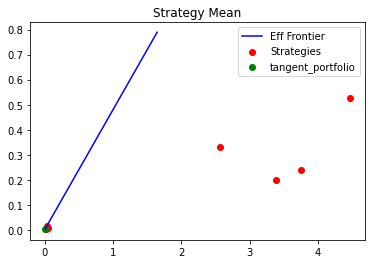

In [50]:
rf_df_new = rf_df.apply(lambda x:0)
EF(Factor_QO,rf_df_new)

#### The sharpe ratio is 0.647

In [51]:
#Qp
odd_Factor_QO = Factor_QO[::2]
even_Factor_QO = Factor_QO[1::2]
weight_for_even = Tangent_weight(odd_Factor_QO,rf_df).T.iloc[0,:]
weight_for_odd = Tangent_weight(even_Factor_QO,rf_df).T.iloc[0,:]
even_outsample = port_const(even_Factor_QO,weight_for_even,'Portfolio_cross')
odd_outsample = port_const(odd_Factor_QO,weight_for_odd,'Portfolio_cross')
portfolio_cross = pd.concat([odd_outsample,even_outsample])
portfolio_cross.sort_index(inplace=True)
portfolio_cross

,Portfolio_cross
date,
1990-01-31,-0.002623
1990-02-28,0.002891
1990-03-31,0.015619
1990-04-30,-0.001523
1990-05-31,-0.002610
...,...
2012-08-31,-0.001919
2012-09-30,-0.000098
2012-10-31,0.002182


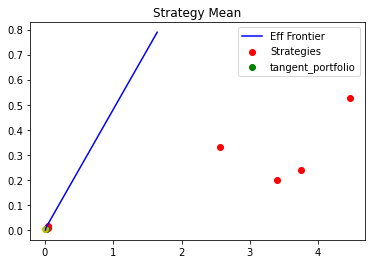

In [52]:
tanp_r = portfolio_cross.mean()
tanp_sig = portfolio_cross.std()
EF(Factor_QO,rf_df_new)
plt.scatter(tanp_sig, tanp_r, label ='new tangent_port',color="y")